In [1]:
from collections import defaultdict
from pathlib import Path
import json
import time
import os

from PIL import Image, ImageDraw
from shapely import wkt
from shapely.geometry import box as Box

from matplotlib import colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Grab all post-disaster json
labels_generator = Path("f_data/xview2/labels").rglob(pattern=f'*post_*.json')

disaster_dict = defaultdict(list)
for label in labels_generator:
    disaster_type = label.name.split('_')[0]
    disaster_dict[disaster_type].append(str(label))

keys = list(disaster_dict.keys())
print("keys:", keys)

# Damage colour dictionary
damage_dict = {"no-damage"    : (0, 255, 0, 50),
               "minor-damage" : (0, 0, 255, 50),
               "major-damage" : (255, 69, 0, 50),
               "destroyed"    : (255, 0, 0, 50),
               "un-classified": (255, 255, 255, 50)}
def read_label(json_path):                             #json_path -> disaster_dict[key][n]
    """ Load metadata """
    with open(json_path) as json_file:
        image_json = json.load(json_file)
        return image_json

def get_damage_type(coord):                            #coord -> json_dict['features']['xy'][n]
    """ Get damage subtype """
    if 'subtype' in coord['properties']:
        return coord['properties']['subtype']
    else:
        return 'un-classified'

###############################################################################
def annotate_img(draw, coords, opaque=False, subtype=None):                        # -> display_img(..., annotated=True)
    """ Mark damaged area  on image """                
    wkt_polygons = []

    # Load shapes
    for coord in coords:
        damage = get_damage_type(coord)

        if not subtype:
            wkt_polygons.append((damage, wkt.loads(coord['wkt'])))
        else:
            if damage==subtype:
                wkt_polygons.append((damage, wkt.loads(coord['wkt'])))

    # Get shape coordinates and draw to image
    for damage, polygon in wkt_polygons:
        x, y = polygon.exterior.coords.xy
        coords = list(zip(x, y))
        if not opaque:
            draw.polygon(coords, damage_dict[damage])
        else:
            draw.polygon(coords, damage_dict[damage][:3] if not subtype else (255, 255, 255))

    del draw

def display_img(json_path, annotated=True, pre=False): #json_path -> disaster_dict[key][n]
    """ Display image """
    if pre: json_path = json_path.replace('post', 'pre')

    img_path = json_path.replace('labels', 'images').replace('json','png')
        
    image_json = read_label(json_path)
    img_name = image_json['metadata']['img_name']
        
    print(img_name)
    
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img, 'RGBA')
    
    if annotated:
        annotate_img(draw, image_json['features']['xy'])

    return img

def display_mask(json_path, subtype=None):
    image_json = read_label(json_path)

    mask = Image.new("RGB", (1024, 1024))
    draw = ImageDraw.Draw(mask)
    annotate_img(draw, image_json['features']['xy'], opaque=True, subtype=subtype)

    return mask


keys: ['woolsey-fire', 'pinery-bushfire', 'sunda-tsunami', 'portugal-wildfire', 'midwest-flooding', 'hurricane-matthew', 'lower-puna-volcano', 'palu-tsunami', 'socal-fire', 'santa-rosa-wildfire', 'nepal-flooding', 'hurricane-harvey', 'tuscaloosa-tornado', 'mexico-earthquake', 'joplin-tornado', 'hurricane-michael', 'hurricane-florence', 'guatemala-volcano', 'moore-tornado']


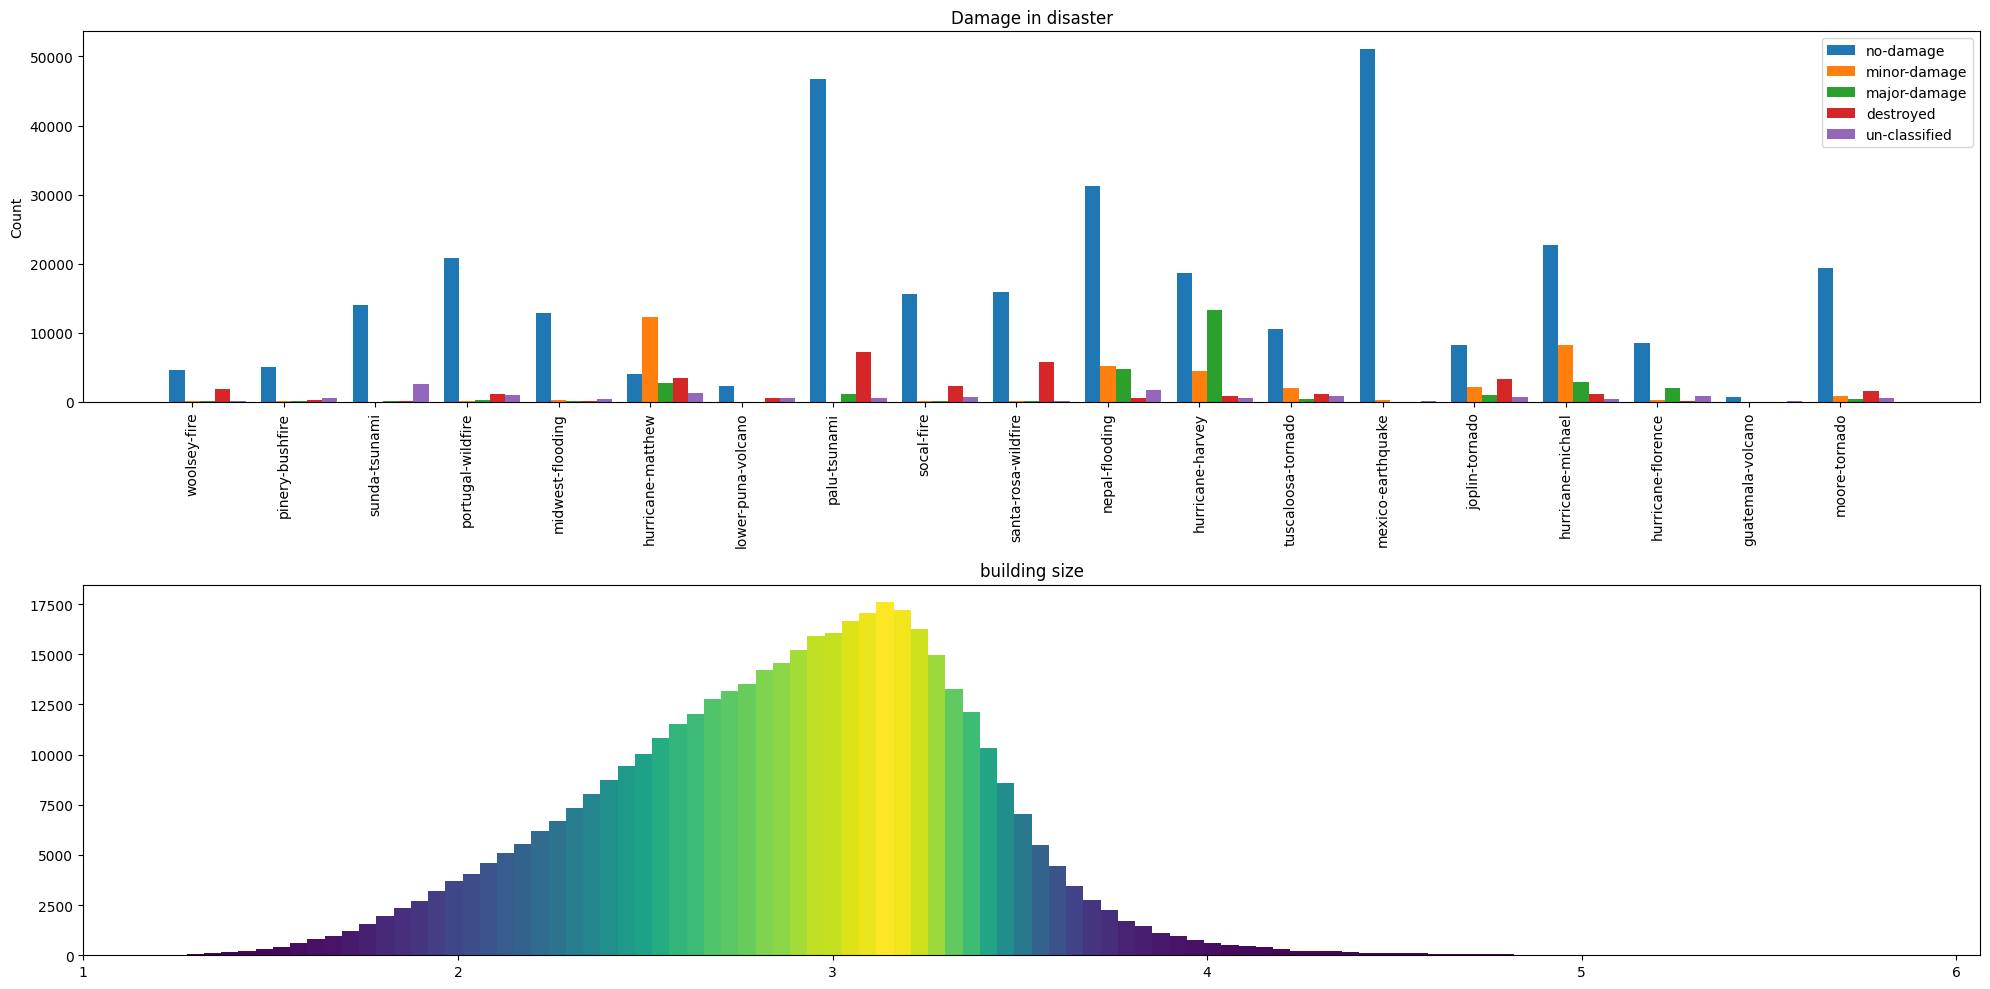

average area  : 1426.2490397314814, Q1-Q99: 105.19467574322651-3907.819315988506
average width : 33.22028258874794, Q1-Q99: 9.830625430593042-66.82591425719494
average height: 32.625426843758525, Q1-Q99: 9.567680787512472-65.45813238819379


In [3]:
# Get some statistics
time_start = time.time()
area = []
widths = []
heights = []
damage_count = {}
damage_count_per_map = []

for key in keys:
    damage_count[key] = {"no-damage"    : 0,
                         "minor-damage" : 0,
                         "major-damage" : 0,
                         "destroyed"    : 0,
                         "un-classified": 0}

    for json_path in disaster_dict[key]:
        name = json_path.split('\\')[-1]
        map_dmg_count = {"name" : name,
                         "no-damage"    : 0,
                         "minor-damage" : 0,
                         "major-damage" : 0,
                         "destroyed"    : 0,
                         "un-classified": 0}
        
        image_json = read_label(json_path)
        coords = image_json['features']['xy']

        for coord in coords:
            dmg_type = coord['properties']['subtype']
            damage_count[key][dmg_type] += 1
            map_dmg_count[dmg_type] += 1
            
            shape = wkt.loads(coord['wkt'])
            left, top, right, bottom = shape.bounds
            bounds = Box(left, top, right, bottom)
            area.append(bounds.area)
            widths.append(right-left)
            heights.append(bottom-top)

        damage_count_per_map.append(map_dmg_count)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bar_colors = [(0, 1, 0), (0, 0, 1), (1, 0.28, 0), (1, 0, 0), (0, 0, 0, 0.5)]

# Damage type spread
x = np.arange(len(keys))*2
width = 0.333
multiplier = 0

for type in damage_dict:
    offset = width * multiplier
    count = [damage_count[key][type] for key in keys]
    rects = ax.bar(x + offset, count, width, label=type)
    multiplier += 1

ax.set_ylabel('Count')
ax.set_title('Damage in disaster')
ax.set_xticks(x + width)
ax.set_xticklabels(keys, rotation = 90)
ax.legend(loc='upper right')

# Area distribution
area_scaled = np.log10(area)

N, bins, patches = ax[1].hist(area_scaled, bins=100)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for frac, patch in zip(fracs, patches):
    color = plt.cm.viridis(norm(frac))
    patch.set_facecolor(color)

plt.tight_layout()
plt.savefig("stats.png")
plt.show()

In [4]:
# present in pandas
df = pd.DataFrame(damage_count).transpose()
df

,no-damage,minor-damage,major-damage,destroyed,un-classified
woolsey-fire,4638,189,126,1876,186
pinery-bushfire,5027,82,99,229,524
sunda-tsunami,14078,0,100,179,2590
portugal-wildfire,20787,176,296,1090,1064
midwest-flooding,12819,246,193,165,473
hurricane-matthew,4058,12331,2717,3524,1334
lower-puna-volcano,2277,49,26,504,554
palu-tsunami,46796,1,1178,7203,611
socal-fire,15697,136,110,2333,693
santa-rosa-wildfire,15843,121,95,5810,86


In [6]:
df2 = pd.DataFrame(damage_count_per_map)
df2['total_item'] = df2['no-damage'] + df2['minor-damage'] + df2['destroyed'] + df2['un-classified']
df2 = df2.sort_values("total_item", ascending=False)
df2.to_json('f_data/xview2/distribution.json')
df2

,name,no-damage,minor-damage,major-damage,destroyed,un-classified,total_item
0,f_data/xview2/labels/woolsey-fire_00000256_pos...,0,0,0,0,0,0
1,f_data/xview2/labels/woolsey-fire_00000304_pos...,0,0,0,0,0,0
2,f_data/xview2/labels/woolsey-fire_00000310_pos...,0,0,0,0,0,0
3,f_data/xview2/labels/woolsey-fire_00000209_pos...,0,0,0,0,0,0
4,f_data/xview2/labels/woolsey-fire_00000499_pos...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
11029,f_data/xview2/labels/moore-tornado_00000190_po...,20,0,0,0,0,20
11030,f_data/xview2/labels/moore-tornado_00000027_po...,62,27,18,47,0,136
11031,f_data/xview2/labels/moore-tornado_00000213_po...,13,0,2,4,3,20
11032,f_data/xview2/labels/moore-tornado_00000068_po...,96,0,0,0,1,97
